<h1 style="text-align: center;" markdown="1"><font color=green>Gentrified or not?</font> </h1>

<font color=green>** Gentrification **</font>   
The process of renovation of deteriorated urban neighborhoods by means of the influx of more affluent residents. 

<font color=green>**Why this project?**</font> 
1. Rich and open data sources
1. Socioeconomic impact
1. Useful tool for policy makers, residents, investors

<font color=green>** How I am going to tackle this problem **:</font> <br>
+ A machine learning model that captures current gentrification trend and predicts future. Signals will be used are:
    - ** housing **: % change house values, % rent, % renters etc
    - ** population **: income, %low-income, %high-income, high education, race etc
    - ** location and infrastructures **: safety, proximity to affluent neighborhoods, public transits, noval business
    - ** others **: taxi riders, social-network check-ins, news/twitter sentiment
+ A interactive tool that enables people to explore and understand gentrification better 

<h2 style="text-align: center;" markdown="1"><font color=black>This Notebook </font> </h2>


**Data used in this notebook:**
1. Zillow research data  
https://www.zillow.com/research/data/#bulk
1. Crime data from SF government https://data.sfgov.org
1. US Census ACS data fact finder
https://factfinder.census.gov/faces/nav/jsf/pages/guided_search.xhtml


** Contents: **

1. Gather data
2. Check and clean data
3. Visualizations


on basic probability, statistics, and programming. 
we urge you to be prepared to pitch your project by explaining your analysis and what you hope to do. 
You will be assessed primarily based on the strength of your existing work and analysis. 

- Why should your project be interesting to a broad audience? 
    Being able to relate your project to a personal interest or experience makes the message more compelling.

- Have a memorable take-away: 
    There are two types of take-aways: technical ones (e.g. improved accuracy by 20%) 
- fun facts (e.g. charitable giving as a percentage of income is highest for the poorest and wealthiest Americans. 
   You should have both in your presentation. How do you find memorable facts? 
    
- Slice your dataset by categories that are of broad interest and try lots of ideas and report only the most interesting.
- Emphasize how much data you analyzed and the tools and techniques you're using (e.g. ran a mapreduce on 60TB of consumer reviews). Presentations are all about bragging so take this opportunity to brag!
Be Concise and Be Prepared: Rehearse your presentation so that you can deliver it concisely in 2-3 minutes. Don't read off a prepared script — or at least don't sound like you're doing it!


<h2 style="text-align: center;" markdown="1">Import modules</h2>


In [1]:
import pandas as pd
import numpy as np
import time
import datetime

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
import fiona
import shapefile
from matplotlib.collections import PatchCollection
from sodapy import Socrata
from descartes import PolygonPatch

# API
import requests
import json
from census import Census
from us import states

import statsmodels.api as sm
import matplotlib.pylab as plt
from pandas.tools.plotting import andrews_curves

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


/Users/fangjie/Workspace/virtual-environments/new/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<h2 style="text-align: center;" markdown="1"><font color=green>How we quantitatively define gentrification in mathmatical words?</font> </h2>

1. overall population <font color=red> ↑ </font> : low-income households <font color=red> ↓ 40% or more </font>
2. overall population <font color=red> ↓ </font> : the rate of low-income households <font color=red> ↓  40% or more </font>drastically than the overall population decline


> ## population and income data
Downloaded from US Census Bureau
https://factfinder.census.gov/faces/nav/jsf/pages/guided_search.xhtml

> American Community Survey: ACS, (2011-2015) 5 year survey, many separate files

In [2]:
# SF_zip code quried from googlemap
SF_zip =['94102', '94103', '94104', '94105', '94107', '94108', '94109', '94110', '94111', '94112', '94114', '94115', '94116', '94117', '94118', '94121', '94122', '94123', '94124', '94127', '94129', '94130', '94131', '94132', '94133', '94134', '94158']

filepath = '/Users/fangjie/Workspace/mockinterviews/Data_Incubator/data/'
# loadincome from S1902 
for year in ['11', '12','13','14','15']:
    name = 'df_income_'+ year
    vars()[name] = pd.read_csv(filepath+'ACS_'+year+'_5YR_S1902/ACS_'+year+'_5YR_S1902_with_ann.csv')
    # select SF data (GEO.id2 zipcodes)
    vars()[name+'_SF']= vars()[name][vars()[name]['GEO.id2'].astype(str).isin(SF_zip)]
    
    # rename relevant columns
   # vars()[name+'_SF'] = vars()[name+'_SF'].rename(columns = {'HC01_EST_VC02':'total_household_'+year})
    vars()[name+'_SF'] = vars()[name+'_SF'].rename(columns = {'HC02_EST_VC02':'mean_'+year})
    
    ## load S1901
    name = 'df_pop_'+ year
    vars()[name] = pd.read_csv(filepath+'ACS_'+year+'_5YR_S1901/ACS_'+year+'_5YR_S1901_with_ann.csv')
    # select SF data (GEO.id2 zipcodes)
    vars()[name+'_SF']= vars()[name][vars()[name]['GEO.id2'].astype(str).isin(SF_zip)]
    # rename relevant columns
    vars()[name+'_SF'] = vars()[name+'_SF'].rename(columns = {'HC01_EST_VC01':'total_household_'+year})
    

> data checking

In [3]:
df_pop_11_SF.head()

,GEO.id,GEO.id2,GEO.display-label,total_household_11,HC01_MOE_VC01,HC02_EST_VC01,HC02_MOE_VC01,HC03_EST_VC01,HC03_MOE_VC01,HC04_EST_VC01,...,HC04_EST_VC19,HC04_MOE_VC19,HC01_EST_VC20,HC01_MOE_VC20,HC02_EST_VC20,HC02_MOE_VC20,HC03_EST_VC20,HC03_MOE_VC20,HC04_EST_VC20,HC04_MOE_VC20
972,8600000US94102,94102,ZCTA5 94102,14884,591,3013,367,1867,293,11871,...,(X),(X),(X),(X),(X),(X),(X),(X),24.0,(X)
973,8600000US94103,94103,ZCTA5 94103,11230,505,3194,411,1996,309,8036,...,(X),(X),(X),(X),(X),(X),(X),(X),27.0,(X)
974,8600000US94104,94104,ZCTA5 94104,189,73,26,42,10,26,163,...,(X),(X),(X),(X),(X),(X),(X),(X),22.7,(X)
975,8600000US94105,94105,ZCTA5 94105,2769,349,875,211,799,204,1894,...,(X),(X),(X),(X),(X),(X),(X),(X),22.2,(X)
976,8600000US94107,94107,ZCTA5 94107,13028,504,5378,482,3893,381,7650,...,(X),(X),(X),(X),(X),(X),(X),(X),15.1,(X)


In [4]:
df_pop_15_SF.head()

,GEO.id,GEO.id2,GEO.display-label,total_household_15,HC01_MOE_VC01,HC02_EST_VC01,HC02_MOE_VC01,HC03_EST_VC01,HC03_MOE_VC01,HC04_EST_VC01,...,HC04_EST_VC19,HC04_MOE_VC19,HC01_EST_VC20,HC01_MOE_VC20,HC02_EST_VC20,HC02_MOE_VC20,HC03_EST_VC20,HC03_MOE_VC20,HC04_EST_VC20,HC04_MOE_VC20
973,8600000US94102,94102,ZCTA5 94102,16463,631,4149,457,2676,357,12314,...,(X),(X),(X),(X),(X),(X),(X),(X),20.1,(X)
974,8600000US94103,94103,ZCTA5 94103,12728,514,3568,442,2321,407,9160,...,(X),(X),(X),(X),(X),(X),(X),(X),24.1,(X)
975,8600000US94104,94104,ZCTA5 94104,176,48,74,32,56,34,102,...,(X),(X),(X),(X),(X),(X),(X),(X),20.6,(X)
976,8600000US94105,94105,ZCTA5 94105,3778,482,1253,392,1132,368,2525,...,(X),(X),(X),(X),(X),(X),(X),(X),17.8,(X)
977,8600000US94107,94107,ZCTA5 94107,13743,682,6066,499,4797,492,7677,...,(X),(X),(X),(X),(X),(X),(X),(X),18.7,(X)


In [5]:
df_income_15_SF.shape  # 11-15

(27, 111)

> calculate mean income each year

In [6]:
## the data from all years have the same structure, 27 zipcodes
# create new table with mean income from 2011-2015, zipcode, year, mean_income
#df_income = pd.merge(df_income_11_SF[['GEO.id2','HC02_EST_VC02']], 
#                     df_income_12_SF[['GEO.id2','HC02_EST_VC02']], 
#                     on='GEO.id2', suffixes = ['_2011', '_2012']
#                           )
dfs = [df_income_11_SF[['GEO.id2','mean_11']], df_income_12_SF[['GEO.id2','mean_12']], df_income_13_SF[['GEO.id2','mean_13']], df_income_14_SF[['GEO.id2','mean_14']],df_income_15_SF[['GEO.id2','mean_15']]]
#dfs = [df_income_11_SF[['GEO.id2','HC02_EST_VC02']], df_income_12_SF[['GEO.id2','HC02_EST_VC02']]]
df_income = reduce(lambda left,right: pd.merge(left,right,on='GEO.id2'), dfs)
df_income.head()

,GEO.id2,mean_11,mean_12,mean_13,mean_14,mean_15
0,94102,45260,48334,48910,54084,56397
1,94103,69089,73372,77913,77778,90489
2,94104,55996,96572,114709,183221,143978
3,94105,169743,211655,238101,239576,247624
4,94107,147923,150750,145343,150643,151928


In [7]:
df_income.dtypes

GEO.id2    object
mean_11    object
mean_12    object
mean_13    object
mean_14    object
mean_15    object
dtype: object

In [8]:
cols = ['mean_11', 'mean_12', 'mean_13','mean_14','mean_15']
df_income[cols] = df_income[cols].apply(pd.to_numeric, errors='coerce', axis=1)
df_income.dtypes

GEO.id2    object
mean_11     int64
mean_12     int64
mean_13     int64
mean_14     int64
mean_15     int64
dtype: object

In [9]:
df_income.head()

,GEO.id2,mean_11,mean_12,mean_13,mean_14,mean_15
0,94102,45260,48334,48910,54084,56397
1,94103,69089,73372,77913,77778,90489
2,94104,55996,96572,114709,183221,143978
3,94105,169743,211655,238101,239576,247624
4,94107,147923,150750,145343,150643,151928


> quick visual display of household income each year

Text(0.5,1,u'mean household income from 2011-2015')

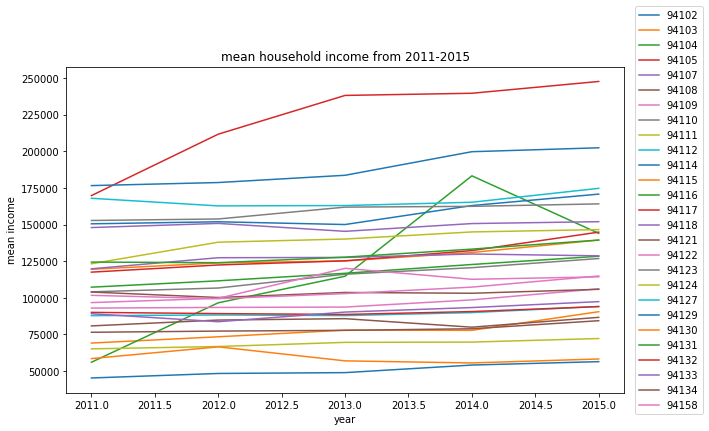

In [10]:
#df_income.set_index('GEO.id2',inplace=True)

x = [2011,2012,2013,2014,2015]
y = df_income.iloc[:,1:6].copy().T

fig, ax = plt.subplots(1,1,figsize = (10,6))
plt.plot(x,y)
plt.legend(df_income['GEO.id2'], loc=9, bbox_to_anchor=(1.08, 1.2))
plt.xlabel('year')
plt.ylabel('mean income')
plt.title('mean household income from 2011-2015')

In [11]:
# increase rate at 2015 cf to 2011
df_income['increase_rate'] = (df_income['mean_15']-df_income['mean_11'])*100.0/df_income['mean_11']
df_income = df_income.sort_values(by=['increase_rate'],ascending=False)
df_income.mean()

GEO.id2          3.485368e+133
mean_11           1.071962e+05
mean_12           1.122313e+05
mean_13           1.162496e+05
mean_14           1.218218e+05
mean_15           1.253307e+05
increase_rate     1.912894e+01
dtype: float64

In [12]:
# use the median increase rate as a criteria to judge whether a zipcode has been gentrified or not
rate_criteria = df_income.increase_rate.median()

> Regions where income has increased by more than 40% 

In [93]:
df_gen = df_income[df_income['increase_rate']>1.4*rate_criteria]
df_gen['GEO.id2'].astype(int)

2     94104
3     94105
1     94103
0     94102
13    94117
7     94110
12    94116
8     94111
26    94158
Name: GEO.id2, dtype: int64

In [14]:
df_gen

,GEO.id2,mean_11,mean_12,mean_13,mean_14,mean_15,increase_rate
2,94104,55996,96572,114709,183221,143978,157.121937
3,94105,169743,211655,238101,239576,247624,45.881715
1,94103,69089,73372,77913,77778,90489,30.974540
0,94102,45260,48334,48910,54084,56397,24.606717
13,94117,117486,122381,125203,132201,144804,23.252132
7,94110,104044,106657,116075,120535,126780,21.852293
12,94116,107232,111568,116706,122711,128327,19.672299
8,94111,123222,137929,140092,144931,146520,18.907338
26,94158,96700,99614,120081,112612,114277,18.176836


In [102]:
df_gen = df_gen.drop([26]) # not found in zipcode database

In [103]:
df_gen.dtypes

GEO.id2           object
mean_11            int64
mean_12            int64
mean_13            int64
mean_14            int64
mean_15            int64
increase_rate    float64
dtype: object

In [104]:
# find coordinates for zipcodes
from pyzipcode import ZipCodeDatabase
zcdb = ZipCodeDatabase()
df_gen['lon'] = df_gen.apply(lambda x: zcdb[x['GEO.id2']].longitude, axis = 1)
df_gen['lat'] = df_gen.apply(lambda x: zcdb[x['GEO.id2']].latitude, axis = 1)
df_gen

,GEO.id2,mean_11,mean_12,mean_13,mean_14,mean_15,increase_rate,lon,lat
2,94104,55996,96572,114709,183221,143978,157.121937,-122.40190,37.791728
3,94105,169743,211655,238101,239576,247624,45.881715,-122.39570,37.789228
1,94103,69089,73372,77913,77778,90489,30.974540,-122.41087,37.772329
0,94102,45260,48334,48910,54084,56397,24.606717,-122.41915,37.779329
13,94117,117486,122381,125203,132201,144804,23.252132,-122.44276,37.770937
7,94110,104044,106657,116075,120535,126780,21.852293,-122.41545,37.748730
12,94116,107232,111568,116706,122711,128327,19.672299,-122.48578,37.743381
8,94111,123222,137929,140092,144931,146520,18.907338,-122.40027,37.798228


> calculate income increase rate etc

In [105]:
df_pop_diff = pd.merge(df_pop_11_SF[['GEO.id2','total_household_11']], 
                    df_pop_15_SF[['GEO.id2','total_household_15']], 
                    on='GEO.id2')

df_pop_diff['total_diff'] = df_pop_diff['total_household_15'].astype(int)-df_pop_diff['total_household_11'].astype(int)

In [106]:
# income mean for each year
df_income.describe()

,mean_11,mean_12,mean_13,mean_14,mean_15,increase_rate
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,107196.185185,112231.333333,116249.555556,121821.814815,125330.740741,19.128938
std,36179.853517,38047.387511,41065.325905,44679.320978,43583.071468,29.304217
min,45260.000000,48334.000000,48910.000000,54084.000000,56397.000000,-0.453038
25%,84301.000000,86519.500000,88228.500000,90236.000000,94015.000000,7.314236
50%,103909.000000,100179.000000,116075.000000,120535.000000,126780.000000,12.973473
75%,123789.500000,132630.500000,133901.000000,147787.000000,145662.000000,19.289819
max,176556.000000,211655.000000,238101.000000,239576.000000,247624.000000,157.121937


In [107]:
# find population income lower than 40% of the mean income 
np.array([107196.185185, 112231.333333, 116249.555556,121821.814815,125330.740741])*0.4
# they all fall in category between HC01_EST_VC_02 and  HC01_EST_VC_02 

array([ 42878.474074 ,  44892.5333332,  46499.8222224,  48728.725926 ,
        50132.2962964])

In [108]:
# get low income population in 2011 and 2015
df_pop_diff = pd.merge(df_pop_diff, 
                    df_pop_11_SF[['GEO.id2','HC01_EST_VC02','HC01_EST_VC03','HC01_EST_VC04','HC01_EST_VC05','HC01_EST_VC06']], 
                    on='GEO.id2')

df_pop_diff.head()


,GEO.id2,total_household_11,total_household_15,total_diff,HC01_EST_VC02,HC01_EST_VC03,HC01_EST_VC04,HC01_EST_VC05,HC01_EST_VC06
0,94102,14884,16463,1579,18.6,17.2,17.5,9.1,10.3
1,94103,11230,12728,1498,11.7,13.9,11.5,7.1,11.0
2,94104,189,176,-13,9.0,24.3,10.1,29.1,0.0
3,94105,2769,3778,1009,3.6,2.7,1.6,4.9,8.0
4,94107,13028,13743,715,5.1,3.1,6.8,4.5,5.1


In [109]:
df_pop_diff['low_11'] = ((df_pop_diff['HC01_EST_VC02'].astype(float)+df_pop_diff['HC01_EST_VC03'].astype(float)\
                        +df_pop_diff['HC01_EST_VC04'].astype(float)+df_pop_diff['HC01_EST_VC05'].astype(float)\
                        +df_pop_diff['HC01_EST_VC06'].astype(float)))/100
columns = ['HC01_EST_VC02', 'HC01_EST_VC03','HC01_EST_VC04','HC01_EST_VC05','HC01_EST_VC06']
df_pop_diff.drop(columns, inplace=True, axis=1)
df_pop_diff.head()

,GEO.id2,total_household_11,total_household_15,total_diff,low_11
0,94102,14884,16463,1579,0.727
1,94103,11230,12728,1498,0.552
2,94104,189,176,-13,0.725
3,94105,2769,3778,1009,0.208
4,94107,13028,13743,715,0.246


In [110]:
# get low income population 2015
df_pop_diff = pd.merge(df_pop_diff, 
                    df_pop_15_SF[['GEO.id2','HC01_EST_VC02','HC01_EST_VC03','HC01_EST_VC04','HC01_EST_VC05','HC01_EST_VC06']], 
                    on='GEO.id2')


df_pop_diff['low_15'] = ((df_pop_diff['HC01_EST_VC02'].astype(float)+df_pop_diff['HC01_EST_VC03'].astype(float)\
                        +df_pop_diff['HC01_EST_VC04'].astype(float)+df_pop_diff['HC01_EST_VC05'].astype(float)\
                        +df_pop_diff['HC01_EST_VC06'].astype(float)))/100
columns = ['HC01_EST_VC02', 'HC01_EST_VC03','HC01_EST_VC04','HC01_EST_VC05','HC01_EST_VC06']
df_pop_diff.drop(columns, inplace=True, axis=1)

In [111]:
df_pop_diff.head()

,GEO.id2,total_household_11,total_household_15,total_diff,low_11,low_15
0,94102,14884,16463,1579,0.727,0.667
1,94103,11230,12728,1498,0.552,0.538
2,94104,189,176,-13,0.725,0.529
3,94105,2769,3778,1009,0.208,0.107
4,94107,13028,13743,715,0.246,0.245


In [112]:
df_pop_diff['population_increase'] = (df_pop_diff['total_household_15'].astype(int)-df_pop_diff['total_household_11'].astype(int))*1.0/df_pop_diff['total_household_11'].astype(float)

In [113]:
df_pop_diff['low_increase_rate'] = (df_pop_diff['low_15']-df_pop_diff['low_11'])/df_pop_diff['low_11']
df_pop_diff.head()

,GEO.id2,total_household_11,total_household_15,total_diff,low_11,low_15,population_increase,low_increase_rate
0,94102,14884,16463,1579,0.727,0.667,0.106087,-0.082531
1,94103,11230,12728,1498,0.552,0.538,0.133393,-0.025362
2,94104,189,176,-13,0.725,0.529,-0.068783,-0.270345
3,94105,2769,3778,1009,0.208,0.107,0.364391,-0.485577
4,94107,13028,13743,715,0.246,0.245,0.054882,-0.004065


1. overall population <font color=red> ↑ </font> : low-income households <font color=red> ↓ more than 40%</font>
2. overall population <font color=red> ↓ </font> : the rate of low-income households <font color=red> ↓ </font> at a 40% or more faster rate than the overall population decline

In [114]:
df_pop_gen = df_pop_diff[((df_pop_diff['population_increase'] > 0) & \
             (df_pop_diff['low_increase_rate'] < -0.4))\
            | ((df_pop_diff['population_increase'] < 0) \
               & (abs(df_pop_diff['low_increase_rate']) > 1.4*abs(df_pop_diff['population_increase'])))]

> zipcodes of regions that has been gentrified according to mentioned criteria

In [115]:
df_pop_gen['GEO.id2']

2     94104
3     94105
8     94111
10    94114
13    94117
15    94121
19    94127
22    94131
23    94132
24    94133
Name: GEO.id2, dtype: object

> find coordinates for gentrified zip code areas
> Geocoding

In [116]:
df_pop_gen.head()

,GEO.id2,total_household_11,total_household_15,total_diff,low_11,low_15,population_increase,low_increase_rate
2,94104,189,176,-13,0.725,0.529,-0.068783,-0.270345
3,94105,2769,3778,1009,0.208,0.107,0.364391,-0.485577
8,94111,2227,2118,-109,0.337,0.362,-0.048945,0.074184
10,94114,16733,16456,-277,0.223,0.185,-0.016554,-0.170404
13,94117,18468,18362,-106,0.278,0.232,-0.005740,-0.165468


In [117]:
from pygeocoder import Geocoder
results = Geocoder.reverse_geocode(37.70808923327349, -122.51494757834968,)

In [118]:
results.postal_code

u'94132'

In [119]:
df_pop_gen.dtypes

GEO.id2                 object
total_household_11      object
total_household_15      object
total_diff               int64
low_11                 float64
low_15                 float64
population_increase    float64
low_increase_rate      float64
dtype: object

In [120]:
from pyzipcode import ZipCodeDatabase
zcdb = ZipCodeDatabase()
df_pop_gen['lon'] = df_pop_gen.apply(lambda x: zcdb[x['GEO.id2']].longitude, axis = 1)
df_pop_gen['lat'] = df_pop_gen.apply(lambda x: zcdb[x['GEO.id2']].latitude, axis = 1)
     
df_pop_gen

,GEO.id2,total_household_11,total_household_15,total_diff,low_11,low_15,population_increase,low_increase_rate,lon,lat
2,94104,189,176,-13,0.725,0.529,-0.068783,-0.270345,-122.40190,37.791728
3,94105,2769,3778,1009,0.208,0.107,0.364391,-0.485577,-122.39570,37.789228
8,94111,2227,2118,-109,0.337,0.362,-0.048945,0.074184,-122.40027,37.798228
10,94114,16733,16456,-277,0.223,0.185,-0.016554,-0.170404,-122.43512,37.758434
13,94117,18468,18362,-106,0.278,0.232,-0.005740,-0.165468,-122.44276,37.770937
15,94121,17463,17388,-75,0.347,0.365,-0.004295,0.051873,-122.49265,37.778729
19,94127,7258,7208,-50,0.163,0.192,-0.006889,0.177914,-122.45970,37.734964
22,94131,13262,13254,-8,0.249,0.231,-0.000603,-0.072289,-122.43780,37.741797
23,94132,10551,10391,-160,0.358,0.376,-0.015164,0.050279,-122.47958,37.724231
24,94133,13444,13230,-214,0.498,0.475,-0.015918,-0.046185,-122.41018,37.801878


> a sneak peek at where are those zip zode regions

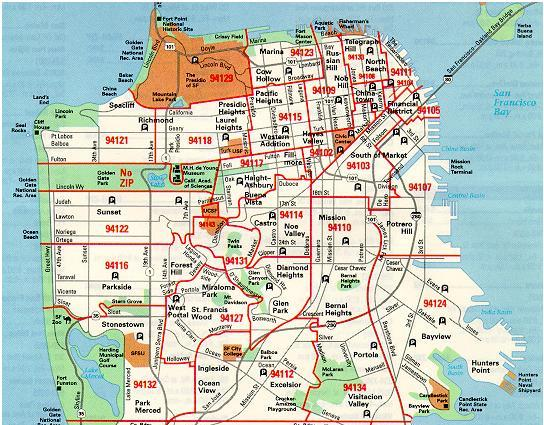

In [121]:
from IPython.display import Image
PATH = "/Users/fangjie/Desktop/"
Image(filename = PATH + "SF_Zip-Code_Map.jpg", width=600, height=600)

> - mission 
> - soma
> - financial district
> - north beach

<h2 style="text-align: center;" markdown="1">Housing price</h2>

> ## housing data
> Files (in .CSV format) downloaded from Zillow Research https://www.zillow.com/research/data/#bulk
> Organized in different geographies
- Obtain San Francisco data from all other cities
- What is the temporal change of house prices in gentrified regions compared to the rest?

In [122]:
# House value data, Data source: Zillow https://www.zillow.com/research/data/#bulk
df_price = pd.read_csv('/Users/fangjie/Workspace/mockinterviews/Data_Incubator/data/Neighborhood/Neighborhood_Zhvi_AllHomes.csv')

In [123]:
df_price.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09
0,274772,Northeast Dallas,Dallas,TX,Dallas-Fort Worth,Dallas,1,NaN,NaN,NaN,...,277500,278300,281600,285900,289900,292900,292900,291800,290900,290100
1,192689,Paradise,Las Vegas,NV,Las Vegas,Clark,2,115400.0,115300.0,115500.0,...,196500,199100,201400,202900,204200,206300,208900,211100,213400,215500
2,112345,Maryvale,Phoenix,AZ,Phoenix,Maricopa,3,58900.0,58900.0,58900.0,...,147500,148300,148600,148900,149500,150800,152500,153900,155100,156100
3,27080,Sherman Oaks,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,4,216200.0,218200.0,218900.0,...,869700,872500,876200,879500,882400,886400,891100,896200,903200,910200
4,118208,South Los Angeles,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,5,117600.0,118700.0,119600.0,...,401900,406100,411000,417300,423400,427100,429700,432500,435300,437500


In [124]:
df_price.dtypes

RegionID        int64
RegionName     object
City           object
State          object
Metro          object
CountyName     object
SizeRank        int64
1996-04       float64
1996-05       float64
1996-06       float64
1996-07       float64
1996-08       float64
1996-09       float64
1996-10       float64
1996-11       float64
1996-12       float64
1997-01       float64
1997-02       float64
1997-03       float64
1997-04       float64
1997-05       float64
1997-06       float64
1997-07       float64
1997-08       float64
1997-09       float64
1997-10       float64
1997-11       float64
1997-12       float64
1998-01       float64
1998-02       float64
               ...   
2015-04         int64
2015-05         int64
2015-06         int64
2015-07         int64
2015-08         int64
2015-09         int64
2015-10         int64
2015-11         int64
2015-12         int64
2016-01         int64
2016-02       float64
2016-03       float64
2016-04       float64
2016-05       float64
2016-06   

> quick look at housing price vs time 

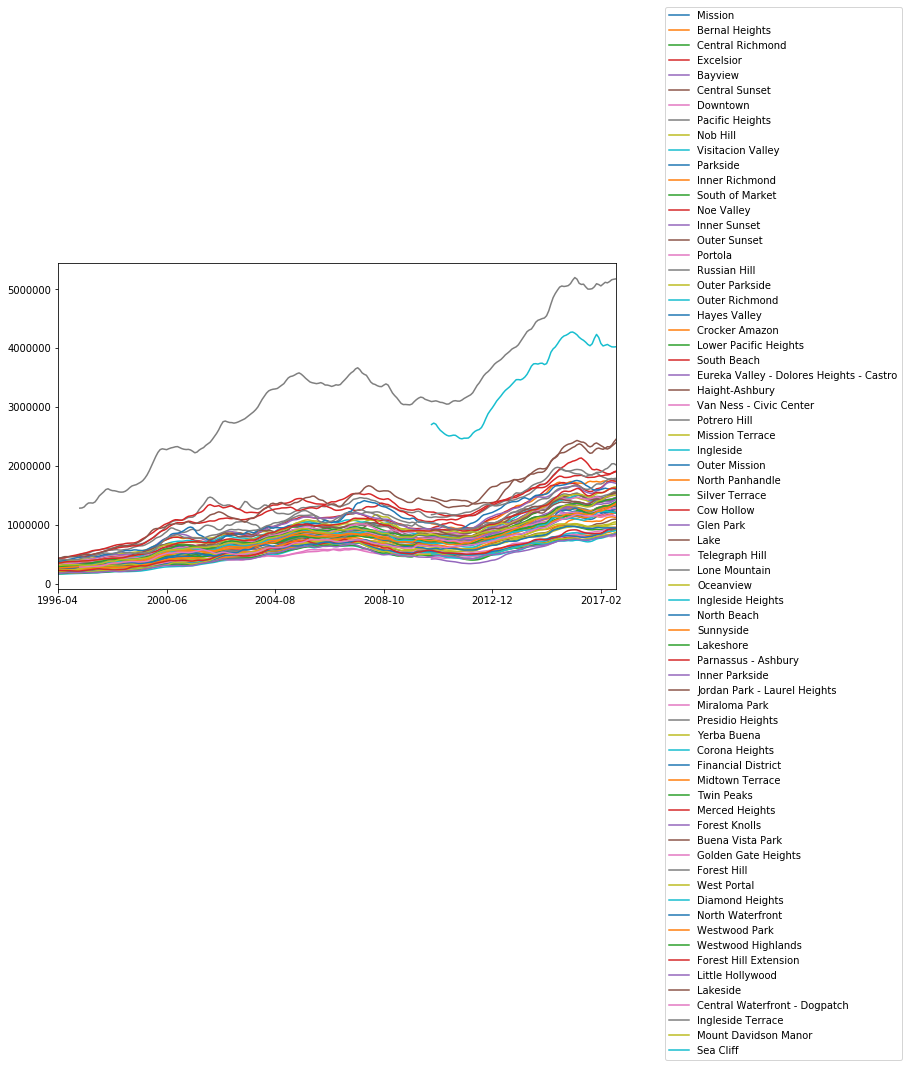

In [125]:
fig, ax = plt.subplots(1,1,figsize = (10,6))
d = df_price[df_price.City == 'San Francisco']
d.set_index(d.RegionName, inplace = True)
t = d[lambda df: df.columns[7:]].transpose()
t.plot(ax = ax)
plt.legend(loc=9, bbox_to_anchor=(1.3, 1.8))

# quick look at what the data looks like

In [126]:
# # of missing values, top 7 regions have same number of missing values
pd.Series(t.isnull().sum()).sort_values(ascending=False).head(10)

RegionName
Sea Cliff            172
Bayview              172
Lakeside             172
Inner Richmond       172
Forest Hill          172
Lake                 172
Ingleside Heights    172
Ingleside             16
Presidio Heights      10
Bernal Heights        10
dtype: int64

> Fliter out 2011 -2015 year data, so that we can compare with other data

In [127]:
df_price = df_price[df_price.City == 'San Francisco']
df_price['avg_price_2011'] = df_price[[col for col in list(df_price) if col.startswith('2011')]].mean(axis = 1, skipna=None)
df_price['avg_price_2015'] = df_price[[col for col in list(df_price) if col.startswith('2015')]].mean(axis = 1, skipna=None)
df_price['avg_price_increase_2011_to_2015'] = 100.0*(df_price['avg_price_2015'] / df_price['avg_price_2011'] - 1)
df_price.set_index(df_price.RegionID, inplace = True)
df_price.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,avg_price_2011,avg_price_2015,avg_price_increase_2011_to_2015
RegionID,,,,,,,,,,,,,,,,,,,,,
274552,274552,Mission,San Francisco,CA,San Francisco,San Francisco,99,226900.0,226100.0,224400.0,...,1292100,1299500,1299800,1301200,1313700,1336700,1357700,702566.666667,1.200008e+06,70.803482
268020,268020,Bernal Heights,San Francisco,CA,San Francisco,San Francisco,314,NaN,NaN,NaN,...,1323600,1333200,1331400,1335500,1346800,1351800,1350600,693591.666667,1.152433e+06,66.154438
117654,117654,Central Richmond,San Francisco,CA,San Francisco,San Francisco,380,327600.0,332100.0,337800.0,...,1421300,1425400,1424900,1419200,1422500,1441900,1462000,784341.666667,1.384692e+06,76.541898
268150,268150,Excelsior,San Francisco,CA,San Francisco,San Francisco,390,190900.0,191300.0,191800.0,...,851500,866900,882300,896300,905900,914400,921900,497141.666667,7.659417e+05,54.069095
272885,272885,Bayview,San Francisco,CA,San Francisco,San Francisco,449,NaN,NaN,NaN,...,795200,808700,820000,826800,828300,834000,843400,374316.666667,7.181667e+05,91.860724


> Quick test: Known Gentrified District (news), mission district 

In [128]:
# the mission district which has been reported to have been gentrified
list_of_gentrification_areas = ['Mission']

# list_of_gentrification_areas = ['Mission','South of Market', 'Van Ness - Civic Center', 'China Town']
# list_of_rich_area = ['']

> House price increase rate significantly higher than other regions?

Text(0,0.5,u'Median Housing Price Increase since 2011')

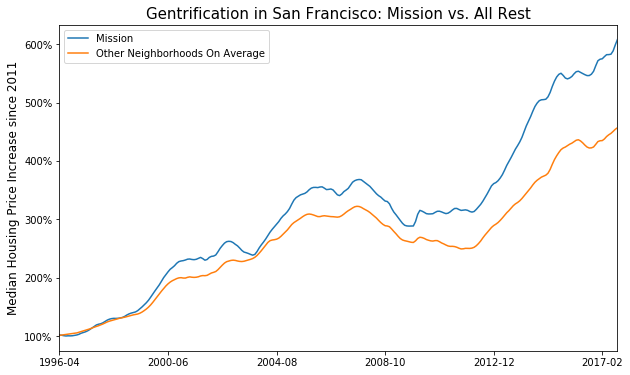

In [129]:
fig, ax = plt.subplots(1,1,figsize = (10,6))
j = 0
t['rescaled_price_accumulate'] = 0
for i, n in enumerate(t.columns):
    t['rescaled_price'] = t[n]/t[n].min()
    
    # directly plot out gentrification areas:
    if n in list_of_gentrification_areas:
        t.rescaled_price.plot(ax = ax, label = n)
    
    # remember non-gentrification areas:
    elif not t.rescaled_price.isnull().values.any():
        t['rescaled_price_accumulate'] += t['rescaled_price']
        j += 1

# at end, plot areas except for gentrification areas on overage..
(t['rescaled_price_accumulate']/j).plot(ax = ax, label = 'Other Neighborhoods On Average')

ax.legend()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
plt.title("Gentrification in San Francisco: Mission vs. All Rest", fontsize = 15)
ax.set_ylabel("Median Housing Price Increase since 2011", fontsize = 12)

> ## crime data
> San Francisco police department data queried from API https://data.sfgov.org
- significant decrease of crime rate often used as an indicator for gentrification

In [130]:
# for now, use 10,000 data points

# sf police data https://data.sfgov.org/resource/PdId.json
# registered business data: vbiu-2p9h for future analysis 
from sodapy import Socrata

client = Socrata("data.sfgov.org", None)

#client = Socrata("data.sfgov.org",
#               "QUkaN797utS2a7CXpveT3eYNA",
#                "fangjieliu.duke@gmail.com",
#                "password")

# dictionaries by sodapy. cuks-n6tp
business = client.get("vbiu-2p9h",limit=100000)
incidents = client.get("PdId",limit=50000)
# Convert to pandas DataFrame
df_business = pd.DataFrame.from_records(business)
df_incidents = pd.DataFrame.from_records(incidents)

In [131]:
mask = (df_incidents['date'] < '2015-01-01') & (df_incidents['date'] > '2011-01-01')
df_incidents['date'] = pd.to_datetime(df_incidents['date'])
df_incidents['year'] = df_incidents['date'].dt.year

In [132]:
df_incidents.dtypes

address               object
category              object
date          datetime64[ns]
dayofweek             object
descript              object
incidntnum            object
location              object
pddistrict            object
pdid                  object
resolution            object
time                  object
x                     object
y                     object
year                   int64
dtype: object

In [133]:
df_incidents = df_incidents[mask]

In [134]:
df_i = df_incidents[['x','y','pddistrict','year','category']]

In [135]:
df_i['x'] = df_i['x'].astype(float)
df_i['y'] = df_i['y'].astype(float)

In [136]:
df_i.head()

,x,y,pddistrict,year,category
2,-122.444707,37.724931,INGLESIDE,2013,ASSAULT
4,-122.414056,37.782793,TENDERLOIN,2013,OTHER OFFENSES
9,-122.408761,37.715900,INGLESIDE,2011,NON-CRIMINAL
11,-122.416015,37.755546,MISSION,2011,LARCENY/THEFT
12,-122.437928,37.719328,INGLESIDE,2014,"SEX OFFENSES, FORCIBLE"


> find corresponding zipcode zones from coordinates

In [137]:
#from googlemaps import GoogleMaps
#gmaps = GoogleMaps(api_key)
#reverse = gmaps.reverse_geocode(38.887563, -77.019929)

In [138]:
df_i1 = df_i.groupby(['pddistrict','year'], as_index=False)[['x','y']].agg(['mean', 'count'])

In [139]:
#df1 = df.groupby(['pddistrict','year'], as_index=False)[['x','y']].agg(['mean', 'count'])
df_i1.head(20)

x                y      
                       mean count       mean count
pddistrict year                                   
BAYVIEW    2011 -122.393556   397  37.735935   397
           2012 -122.394011   425  37.737754   425
           2013 -122.393429   489  37.738282   489
           2014 -122.392648   402  37.736982   402
CENTRAL    2011 -122.409164   370  37.795712   370
           2012 -122.409202   423  37.795212   423
           2013 -122.409110   424  37.795482   424
           2014 -122.409113   492  37.795941   492
INGLESIDE  2011 -122.428986   325  37.727346   325
           2012 -122.428667   352  37.726153   352
           2013 -122.429286   388  37.726754   388
           2014 -122.428860   408  37.726719   408
MISSION    2011 -122.419783   582  37.759847   582
           2012 -122.419176   544  37.759974   544
           2013 -122.420062   602  37.760392   602
           2014 -122.419535   550  37.760256   550
NORTHERN   2011 -122.425857   433  37.785766   433
           2012 -122.426981   481  37.786657   481
           2013 -122.426716   504  37.785852   504
           2014 -122.426287   548  37.785839   548

In [140]:
df_i1.index.get_level_values('pddistrict')

Index([u'BAYVIEW', u'BAYVIEW', u'BAYVIEW', u'BAYVIEW', u'CENTRAL', u'CENTRAL',
       u'CENTRAL', u'CENTRAL', u'INGLESIDE', u'INGLESIDE', u'INGLESIDE',
       u'INGLESIDE', u'MISSION', u'MISSION', u'MISSION', u'MISSION',
       u'NORTHERN', u'NORTHERN', u'NORTHERN', u'NORTHERN', u'PARK', u'PARK',
       u'PARK', u'PARK', u'RICHMOND', u'RICHMOND', u'RICHMOND', u'RICHMOND',
       u'SOUTHERN', u'SOUTHERN', u'SOUTHERN', u'SOUTHERN', u'TARAVAL',
       u'TARAVAL', u'TARAVAL', u'TARAVAL', u'TENDERLOIN', u'TENDERLOIN',
       u'TENDERLOIN', u'TENDERLOIN'],
      dtype='object', name=u'pddistrict')

In [141]:
df_i1.head()

x                y      
                       mean count       mean count
pddistrict year                                   
BAYVIEW    2011 -122.393556   397  37.735935   397
           2012 -122.394011   425  37.737754   425
           2013 -122.393429   489  37.738282   489
           2014 -122.392648   402  37.736982   402
CENTRAL    2011 -122.409164   370  37.795712   370

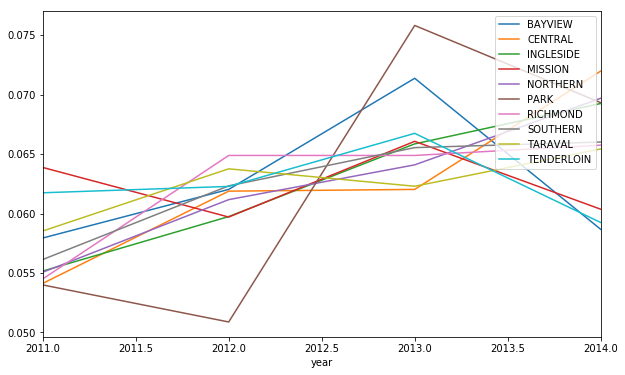

In [142]:
rate_crime=pd.DataFrame({})
fig, ax = plt.subplots(1,1,figsize = (10,6))
for d in df_i1.index.get_level_values('pddistrict').unique():
    df_tmp = df_i1.loc[d]
    rate_crime[d] = 1.0*df_tmp.x['count']/df_tmp.x['count'].sum()/4
    (rate_crime[d]).plot(ax = ax, label = d)

plt.legend(loc = 'upper right')

> let's check the crime rate change

In [143]:
df_i1.index.get_level_values('pddistrict')

Index([u'BAYVIEW', u'BAYVIEW', u'BAYVIEW', u'BAYVIEW', u'CENTRAL', u'CENTRAL',
       u'CENTRAL', u'CENTRAL', u'INGLESIDE', u'INGLESIDE', u'INGLESIDE',
       u'INGLESIDE', u'MISSION', u'MISSION', u'MISSION', u'MISSION',
       u'NORTHERN', u'NORTHERN', u'NORTHERN', u'NORTHERN', u'PARK', u'PARK',
       u'PARK', u'PARK', u'RICHMOND', u'RICHMOND', u'RICHMOND', u'RICHMOND',
       u'SOUTHERN', u'SOUTHERN', u'SOUTHERN', u'SOUTHERN', u'TARAVAL',
       u'TARAVAL', u'TARAVAL', u'TARAVAL', u'TENDERLOIN', u'TENDERLOIN',
       u'TENDERLOIN', u'TENDERLOIN'],
      dtype='object', name=u'pddistrict')

<h2 style="text-align: center;" markdown="1">Overlay crime and housing data</h2>

## prepare data

In [144]:
# load shapefile
# download boundary files of states here: https://www.zillow.com/howto/api/neighborhood-boundaries.htm
shapefilename = '/Users/fangjie/Workspace/mockinterviews/Data_Incubator/data/ZillowNeighborhoods-CA/ZillowNeighborhoods-CA'
# shapefilename = '/Users/fangjie/Downloads/Zoning Districts/geo_export_ff16c4b8-5bf2-4e47-a498-6513bb52d237'
shp = fiona.open(shapefilename+'.shp')
coords = shp.bounds
coords = (-122.51494757834968,
 37.70808923327349,
 -122.35696687665978,
 37.81157429336938)

shp.close()
w, h = coords[2] - coords[0], coords[3] - coords[1]
extra = 0.01
coords

(-122.51494757834968,
 37.70808923327349,
 -122.35696687665978,
 37.81157429336938)

In [145]:
df_gen 

,GEO.id2,mean_11,mean_12,mean_13,mean_14,mean_15,increase_rate,lon,lat
2,94104,55996,96572,114709,183221,143978,157.121937,-122.40190,37.791728
3,94105,169743,211655,238101,239576,247624,45.881715,-122.39570,37.789228
1,94103,69089,73372,77913,77778,90489,30.974540,-122.41087,37.772329
0,94102,45260,48334,48910,54084,56397,24.606717,-122.41915,37.779329
13,94117,117486,122381,125203,132201,144804,23.252132,-122.44276,37.770937
7,94110,104044,106657,116075,120535,126780,21.852293,-122.41545,37.748730
12,94116,107232,111568,116706,122711,128327,19.672299,-122.48578,37.743381
8,94111,123222,137929,140092,144931,146520,18.907338,-122.40027,37.798228


## visualize with basemap

In [146]:
# create basemap object
m = Basemap(
    projection='tmerc', ellps='WGS84',
    lon_0=np.mean([coords[0], coords[2]]),
    lat_0=np.mean([coords[1], coords[3]]),
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - (extra * h), 
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + (extra * h),
    resolution='i',  suppress_ticks=True)

_out = m.readshapefile(shapefilename, name='SF', drawbounds=False, color='none', zorder=2)


In [147]:
# prepare data
# set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(hood_points) for hood_points in m.SF],
    'name': [hood['Name'] for hood in m.SF_info],
    'city': [hood['City'] for hood in m.SF_info],
    'RegionID': [hood['RegionID'] for hood in m.SF_info],
})

# drop some duplicates
df_map = df_map.drop_duplicates(subset = ['RegionID'])
df_map = df_map[df_map.city == 'San Francisco']
df_map['RegionID'] = df_map.RegionID.astype('int')
df_map.set_index(df_map.RegionID, inplace=True)

In [148]:
# join data together
df_map = df_map.join(df_price, how='inner', on = 'RegionID', lsuffix='_map', rsuffix='_price')

In [149]:
#df_map2 = pd.DataFrame({
#    'poly': [Polygon(hood_points) for hood_points in m.SF],
#    'name': [hood['Name'] for hood in m.SF_info],
#    'city': [hood['City'] for hood in m.SF_info],
#    'RegionID': [hood['RegionID'] for hood in m.SF_info],
#    })
#df_map2 = df_map2[df_map2.city == 'San Francisco']
#df_map2['poly_patch']=df_map2['poly'].map(lambda x: PolygonPatch(x, ec='#111111', lw=.8, alpha=1., zorder=4))

#def in_which_region(lat, lon):
#    try:
#        p = Point(m(lon, lat))
#        for index, row in df_map2.iterrows():
#            if row['poly'].contains(p):
#                return row['name']
#                #break
#            #print row['name']
#    except:
#        return None

In [150]:
# df_incidents['hood_name'] = df_incidents.apply(lambda z: in_which_region(float(z.y), float(z.x)), axis = 1)

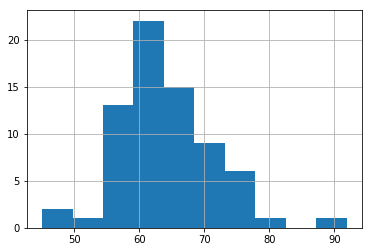

In [151]:
df_map.avg_price_increase_2011_to_2015.hist()

In [152]:
# visualize
breaks = [50.] + [ 60, 70, 80, 90.] + [100]

def self_categorize(entry, breaks):
    for i in range(len(breaks)-1):
        if entry > breaks[i] and entry <= breaks[i+1]:
            return i
    return -1
df_map['jenks_bins'] = df_map.avg_price_increase_2011_to_2015.apply(self_categorize, args=(breaks,))

jenks_labels = ['0-50%% Increase']+[">%d%% Increase"%(perc) for perc in breaks[:-1]]

# from pysal.esda.mapclassify import Natural_Breaks
# breaks = Natural_Breaks(df_map.avg_price_increase_2005_to_2017, initial=0, k=5)
# df_map['jenks_bins'] = -1 #default value if no data exists for this bin
# df_map['jenks_bins'][df_map.avg_price_increase_2005_to_2017 > 0] = breaks.yb
# jenks_labels = ['', "baseline"]+["> %d increase"%(perc) for perc in breaks.bins[:-1]]


In [153]:
def custom_colorbar(cmap, ncolors, labels, **kwargs):    
    """Create a custom, discretized colorbar with correctly formatted/aligned labels.
    cmap: the matplotlib colormap object you plan on using for your graph
    ncolors: (int) the number of discrete colors available
    labels: the list of labels for the colorbar. Should be the same length as ncolors.
    """
    from matplotlib.colors import BoundaryNorm
    from matplotlib.cm import ScalarMappable
        
    norm = BoundaryNorm(range(0, ncolors), cmap.N)
    mappable = ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors+1)+0.5)
    colorbar.set_ticklabels(range(0, ncolors))
    colorbar.set_ticklabels(labels)
    return colorbar

In [154]:
df_gen

,GEO.id2,mean_11,mean_12,mean_13,mean_14,mean_15,increase_rate,lon,lat
2,94104,55996,96572,114709,183221,143978,157.121937,-122.40190,37.791728
3,94105,169743,211655,238101,239576,247624,45.881715,-122.39570,37.789228
1,94103,69089,73372,77913,77778,90489,30.974540,-122.41087,37.772329
0,94102,45260,48334,48910,54084,56397,24.606717,-122.41915,37.779329
13,94117,117486,122381,125203,132201,144804,23.252132,-122.44276,37.770937
7,94110,104044,106657,116075,120535,126780,21.852293,-122.41545,37.748730
12,94116,107232,111568,116706,122711,128327,19.672299,-122.48578,37.743381
8,94111,123222,137929,140092,144931,146520,18.907338,-122.40027,37.798228


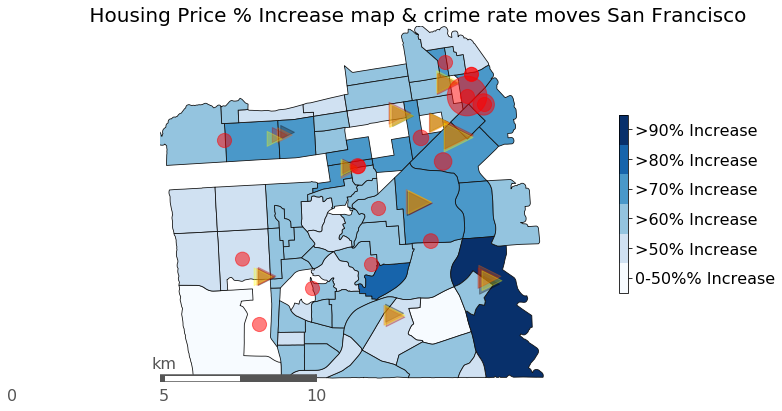

In [159]:
figwidth = 10
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)


cmap = plt.get_cmap('Blues')

# draw neighborhoods with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#111111', lw=.8, alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)

# apply our custom color values onto the patch collection
cmap_list = [cmap(val) for val in (df_map.jenks_bins.values - df_map.jenks_bins.values.min())/(
                  df_map.jenks_bins.values.max()-float(df_map.jenks_bins.values.min()))]
pc.set_facecolor(cmap_list)
ax.add_collection(pc)



#Draw a map scale
m.drawmapscale(coords[0], coords[1],
    coords[0], coords[1], 10.,
    fontsize=16, barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555', fontcolor='#555555',
    zorder=5, ax=ax,)

# ncolors+1 because we're using a "zero-th" color
cbar = custom_colorbar(cmap, ncolors=len(jenks_labels)+1, labels=jenks_labels, shrink=0.5)
cbar.ax.tick_params(labelsize=16)


### overlay incidents data on top of map

import matplotlib.cm as cm
from matplotlib.colors import Normalize

cmap = cm.hot
norm = Normalize(vmin=2011, vmax=2015)

for iyear in range(2000,2015,1):
    aa = df_i1.loc[(df_i1.index.get_level_values('year') == iyear)]
    #cats = aa.index.get_level_values('category').values
    #tempmark = [mapping[cat] for cat in cats]
    lons = aa.x['mean'].values
    lats = aa.y['mean'].values
    incounts= aa.x['count'].values
    x,y = m(lons, lats)
   # plt.scatter(x, y, s=incounts, c=cmap(norm(iyear)),marker=tempmark, alpha=0.3)
    plt.scatter(x, y, s=incounts, c=cmap(norm(iyear)),marker ='>',alpha=0.3)

### mark regions with high income increase rates from 2011-2015
xx, yy = m(np.array(df_pop_gen['lon']), np.array(df_pop_gen['lat']))
plt.scatter(xx,yy,s=200, c='r',alpha=0.5)

xx, yy = m(np.array(df_gen['lon']), np.array(df_gen['lat']))
plt.scatter(xx,yy,s=df_gen.increase_rate*10, c='r',alpha=0.5)

fig.suptitle(" Housing Price % Increase map & crime rate moves San Francisco", fontsize = 5, fontdict={'size':20, 'fontweight':'bold'}, y=0.92)
#ax.set_title("Using location data collected from my Android phone via Google Takeout", fontsize=14, y=0.98)
# qax.text(1.35, 0.04, "Collected from 2012-2014 on Android 4.2-4.4\nGeographic data provided by data.seattle.gov", 
#     ha='right', color='#555555', style='italic', transform=ax.transAxes)
# ax.text(1.35, 0.01, "BeneathData.com", color='#555555', fontsize=16, ha='right', transform=ax.transAxes)

plt.savefig('San Francisco 2011-2015 housing price changes.png', dpi=100, frameon=False, bbox_inches='tight', pad_inches=0.5, facecolor='#F2F2F2')

<h1 style="text-align: center;" markdown="1"><font color=black>Future Work </font> </h1>
1. **More comprehensive datasets**

1. **Machine Learning models to predict gentrification **

1. **Build webapp with interactive visualizations**
